In [167]:
import nest_asyncio
nest_asyncio.apply()

In [168]:
%run model.ipynb
%run data.ipynb

In [169]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import time
import matplotlib.pyplot as plt

In [170]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [171]:
x

,胎次_x,泌乳天數,月齡,配種次數,酪農場代號_A,酪農場代號_B,酪農場代號_C,資料月份_1,資料月份_2,資料月份_3,...,資料月份_6,資料月份_7,資料月份_8,資料月份_9,資料月份_10,資料月份_11,資料月份_12,母牛體重,胎次_y,分娩難易度
0,-0.778490,-0.853648,-1.115650,-0.454949,1,0,0,0,0,1,...,0,0,0,0,0,0,0,-1.286581e-12,-0.868055,6.819770e-15
1,-0.778490,-0.853648,-1.115650,-0.454949,1,0,0,0,0,1,...,0,0,0,0,0,0,0,-1.286581e-12,-0.086893,6.819770e-15
2,-0.778490,-0.660747,-1.063834,-0.454949,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.286581e-12,-0.868055,6.819770e-15
3,-0.778490,-0.660747,-1.063834,-0.454949,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.286581e-12,-0.086893,6.819770e-15
4,-0.778490,-0.441240,-1.012018,0.014484,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.286581e-12,-0.868055,6.819770e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87181,4.941512,-1.292663,4.273228,-0.924381,0,0,1,1,0,0,...,0,0,0,0,0,0,0,6.445178e+00,4.600083,-6.064356e-01
87182,4.941512,-0.461195,4.480492,-0.924381,0,0,1,0,0,0,...,0,0,0,0,0,0,0,6.445178e+00,4.600083,-6.064356e-01
87183,4.941512,-0.254991,4.532309,-0.924381,0,0,1,0,0,0,...,1,0,0,0,0,0,0,6.445178e+00,4.600083,-6.064356e-01
87184,4.941512,-0.062090,4.584125,-0.924381,0,0,1,0,0,0,...,0,1,0,0,0,0,0,6.445178e+00,4.600083,-6.064356e-01


In [172]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1 ,random_state=1)
len(y_train), len(y_valid)

(78467, 8719)

In [173]:
train_data_tensor = torch.tensor(X_train.values.astype('float32')).float()
train_label_tensor = torch.tensor(y_train).float()
valid_data_tensor = torch.tensor(X_valid.values.astype('float32')).float()
valid_label_tensor = torch.tensor(y_valid).float()
train_data_tensor.shape, train_label_tensor.shape

(torch.Size([78467, 22]), torch.Size([78467]))

In [174]:
batch_size = 32
train_tensor = torch.utils.data.TensorDataset(train_data_tensor, train_label_tensor)
valid_tensor = torch.utils.data.TensorDataset(valid_data_tensor, valid_label_tensor)
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True, pin_memory= True)
valid_loader = torch.utils.data.DataLoader(dataset = valid_tensor, batch_size = batch_size, shuffle = True, pin_memory= True)

In [178]:
Model = model(train_data_tensor.shape[1])
#summary(Model, (batch_size, train_data_tensor.shape[1]), device = "cpu")
Model = Model.to(device)
def weights_init_uniform(m):
    classname = m.__class__.__name__
        # for every Linear layer in a model..
    if classname.find('Linear') != -1:
            # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        #m.weight.data 
        m.bias.data.fill_(0)
        m.weight.retain_grad()
        m.bias.retain_grad()
Model.apply(weights_init_uniform)

model(
  (dense1): Linear(in_features=22, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (dense3): Linear(in_features=16, out_features=1, bias=True)
  (ReLU): LeakyReLU(negative_slope=0.01)
)

In [179]:
loss = RMSELoss()
#optimizer = torch.optim.AdamW(Model.parameters(), lr= 0.0001,weight_decay=1e-5)
optimizer = torch.optim.SGD(Model.parameters(),lr = 0.0001)
Epoch = 200

In [177]:
train_loss_list = []
val_loss_list = []
for epoch in range(Epoch):
    since = time.time()
    total_train_loss = 0
    loss_val = 0
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        out = Model(data)
        loss_val = loss(out, label)
        total_train_loss += loss_val
        #loss_val.register_hook(lambda grad: print(grad))        
        loss_val.backward()
        # for m in Model.parameters():
        #     print(m.grad)
        #break
        optimizer.step()
    #break
    for data, label in valid_loader:
        data = data.to(device)
        label = label.to(device)
        out = Model(data)
        loss_val += loss(out,label)
    train_loss_list.append(total_train_loss.item() / len(train_loader))
    val_loss_list.append(loss_val.item() / len(valid_loader))
    now_time = time.time() - since
    print("epoch = ", epoch + 1, " train loss = ", train_loss_list[-1],
    " validation loss = ", val_loss_list[-1])
    print("Training time is:{:.0f}m {:.0f}s".format(now_time // 60, now_time % 60))

epoch =  1  train loss =  26.829185563595598  validation loss =  19.72912374084249
Training time is:0m 3s
epoch =  2  train loss =  19.203185512637585  validation loss =  18.878060253548536
Training time is:0m 2s
epoch =  3  train loss =  18.196863534447616  validation loss =  17.66225782680861
Training time is:0m 2s
epoch =  4  train loss =  16.6106600973298  validation loss =  15.596668956043956
Training time is:0m 2s
epoch =  5  train loss =  13.850519453220546  validation loss =  12.11872299250229
Training time is:0m 2s
epoch =  6  train loss =  10.675598915868324  validation loss =  9.814185732886905
Training time is:0m 2s
epoch =  7  train loss =  9.508701080309825  validation loss =  9.387766855540294
Training time is:0m 2s
epoch =  8  train loss =  9.24428394440481  validation loss =  9.196925795558608
Training time is:0m 2s
epoch =  9  train loss =  9.13258717004688  validation loss =  9.160575671073717
Training time is:0m 2s
epoch =  10  train loss =  9.065143446799837  valid

KeyboardInterrupt: 

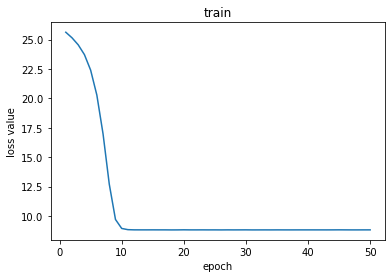

In [56]:
plt.plot(range(1, Epoch + 1), train_loss_list)
plt.title("train")
plt.ylabel("loss value")
plt.xlabel("epoch")
plt.show()

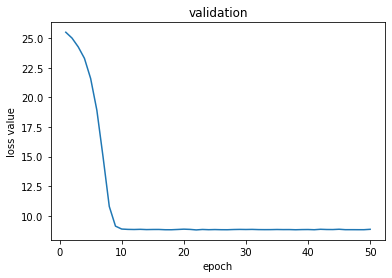

In [57]:
plt.plot(range(1, Epoch + 1), val_loss_list)
plt.title("validation")
plt.ylabel("loss value")
plt.xlabel("epoch")
plt.show()

In [58]:
test_without_ID

,胎次_x,泌乳天數,月齡,配種次數,酪農場代號_A,酪農場代號_B,酪農場代號_C,資料月份_1,資料月份_2,資料月份_3,...,資料月份_6,資料月份_7,資料月份_8,資料月份_9,資料月份_10,資料月份_11,資料月份_12,母牛體重,胎次_y,分娩難易度
0,1.636775,1.671192,2.487608,1.995674,1,0,0,1,0,0,...,0,0,0,0,0,0,0,-1.008221e-12,-0.765127,0.051669
1,1.636775,1.671192,2.487608,1.995674,1,0,0,1,0,0,...,0,0,0,0,0,0,0,-1.008221e-12,0.076127,0.051669
2,1.636775,1.671192,2.487608,1.995674,1,0,0,1,0,0,...,0,0,0,0,0,0,0,-1.008221e-12,0.917382,0.051669
3,1.636775,1.671192,2.487608,1.995674,1,0,0,1,0,0,...,0,0,0,0,0,0,0,-1.008221e-12,1.758636,0.051669
4,1.636775,-1.251356,2.487608,-0.924708,1,0,0,0,1,0,...,0,0,0,0,0,0,0,-1.008221e-12,-0.765127,0.051669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8825,-0.835203,-1.237505,-1.211469,-0.924708,0,0,1,0,0,0,...,1,0,0,0,0,0,0,-1.193437e+00,-0.765127,-0.578055
8826,-0.835203,-1.189027,-1.211469,-0.924708,0,0,1,0,0,0,...,1,0,0,0,0,0,0,-3.467387e+00,-0.765127,-0.578055
8827,-0.835203,-1.195952,-1.317157,-0.924708,0,0,1,0,0,0,...,1,0,0,0,0,0,0,-1.193437e+00,-0.765127,-0.578055
8828,-0.835203,-0.988188,-1.264313,-0.924708,0,0,1,0,0,0,...,0,1,0,0,0,0,0,-1.193437e+00,-0.765127,-0.578055


In [59]:
test_data_tensor = torch.tensor(test_without_ID.values.astype('float32')).float()
test_data_tensor.shape

torch.Size([8830, 22])

In [60]:
res = []

In [75]:
test_tensor = torch.utils.data.TensorDataset(test_data_tensor)
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False, pin_memory= True)

In [88]:
for data in test_loader:
    data = np.squeeze(torch.stack(data))
    data = data.to(device)
    out = Model(data)
    for o in out:
        res.append(o.item())

In [89]:
len(res)

17660

In [90]:
val = pd.DataFrame({'預測乳量':res})
x = test.join(val)
x_group = x.groupby(['ID']).mean()
x_index = list(range(0,x_group.shape[0]))
x_group.index

Int64Index([  480,   742,   743,   744,   745,   793,   794,   800,   801,
              802,
            ...
            37476, 37477, 37478, 37479, 37480, 37481, 37482, 37483, 37484,
            37485],
           dtype='int64', name='ID', length=4263)

Text(0, 0.5, 'predict value')

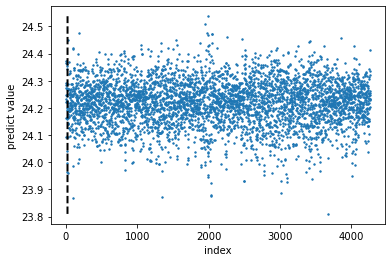

In [91]:
plt.scatter(x_index,x_group['預測乳量'].values,s=2)
plt.plot([x_group['預測乳量'].values.min(), x_group['預測乳量'].values.max()], 
         [x_group['預測乳量'].values.min(),x_group['預測乳量'].values.max()], 'k--', lw=2)
plt.xlabel('index')
plt.ylabel('predict value')

In [92]:
for index in range(x_group.shape[0]):
    submission.loc[index, ['1']] = x_group['預測乳量'].values[index]
submission

,ID,1
0,480,24.094493
1,742,24.272535
2,743,24.232476
3,744,24.163812
4,745,24.220888
...,...,...
4258,37481,24.229086
4259,37482,24.256561
4260,37483,24.233814
4261,37484,24.263790


In [93]:
submission.columns = ['ID','預測乳量']
submission.to_csv('result.csv',index = False)